## Fairness evaluation

In this notebook we will evaluate the fairness of several emotion detection models using the `equity_evaluation_corpus`

In [1]:
%load_ext autoreload
%autoreload 2

from datasets import load_dataset

ds = load_dataset("peixian/equity_evaluation_corpus")

ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'template', 'person', 'gender', 'race', 'emotion', 'emotion word'],
        num_rows: 8640
    })
})

In [2]:
ds["train"][0]

{'sentence': 'Alonzo feels angry.',
 'template': '<person subject> feels <emotion word>.',
 'person': 'Alonzo',
 'gender': 'male',
 'race': 'African-American',
 'emotion': 'anger',
 'emotion word': 'angry'}

In [3]:
df = ds['train'].to_pandas()

In [4]:
from pysentimiento import create_analyzer

analyzer = create_analyzer("emotion", lang="en", model_name="pysentimiento/bert-base-uncased-emotion")

preds = analyzer.predict(df['sentence'])

Map:   0%|          | 0/8640 [00:00<?, ? examples/s]

In [5]:
preds[0]

AnalyzerOutput(output=['anger'], probas={admiration: 0.001, amusement: 0.001, anger: 0.927, annoyance: 0.035, approval: 0.003, caring: 0.003, confusion: 0.005, curiosity: 0.006, desire: 0.002, disappointment: 0.003, disapproval: 0.005, disgust: 0.007, embarrassment: 0.001, excitement: 0.003, fear: 0.002, gratitude: 0.002, grief: 0.003, joy: 0.002, love: 0.002, nervousness: 0.001, optimism: 0.004, pride: 0.002, realization: 0.001, relief: 0.001, remorse: 0.001, sadness: 0.007, surprise: 0.002, neutral: 0.132})

Ok, let's get just the emotions

In [6]:
emotions = [p.output for p in preds]

df["pred"] = emotions

df["pred"].value_counts()

pred
[fear]                         1289
[sadness]                      1255
[neutral]                       972
[annoyance]                     897
[anger]                         691
[joy]                           543
[admiration]                    480
[disappointment]                437
[]                              362
[amusement]                     355
[excitement]                    276
[nervousness]                   223
[surprise]                      175
[excitement, joy]               141
[relief]                        139
[disappointment, sadness]       122
[fear, neutral]                  54
[annoyance, neutral]             26
[anger, neutral]                 23
[admiration, neutral]            21
[caring]                         20
[realization]                    19
[disgust]                        17
[sadness, neutral]               14
[admiration, excitement]         13
[amusement, annoyance]           10
[joy, relief]                    10
[surprise, neutral]    

We'll map this to Ekman emotions (see [Section 5.1 of GoEmotions paper](https://aclanthology.org/2020.acl-main.372.pdf))

In [7]:
emotion_groups = {
    # Here I put disgust in anger
    "anger": ["anger", "annoyance", "disapproval", "disgust"],
    "fear": ["fear", "nervousness"],
    "joy": [
        "admiration", "amusement", "approval", "desire", "caring", "excitement", "gratitude",
        "joy", "love", "optimism", "pride", "relief"
    ],
    "sadness": ["sadness", "remorse", "disappointment", "embarrassment", "grief"],
    "surprise": ["surprise", "realization", "confusion", "curiosity"],
    "neutral": ["neutral"]
}

go2ekman = {v:k for k, vs in emotion_groups.items() for v in vs}

# Check no emotion is missing
len(go2ekman), [emotion for emotion in analyzer.model.config.id2label.values() if emotion not in go2ekman]

(28, [])

In [8]:
# Get Ekman emotions
df["ekman_pred"] = df["pred"].apply(lambda x: list({go2ekman[emotion] for emotion in x}))
df["ekman_pred"].value_counts()

ekman_pred
[joy]                  1992
[sadness]              1814
[anger]                1608
[fear]                 1512
[neutral]               972
[]                      362
[surprise]              194
[neutral, fear]          54
[neutral, anger]         49
[joy, neutral]           33
[neutral, sadness]       15
[joy, anger]             10
[neutral, surprise]       8
[anger, fear]             8
[joy, surprise]           5
[anger, sadness]          3
[sadness, fear]           1
Name: count, dtype: int64

In [9]:
# If neutral and other emotion, remove neutral

df["ekman_pred"] = df["ekman_pred"].apply(lambda x: list(filter(lambda y: y != "neutral", x)) if "neutral" in x and len(x) > 1 else x)
# Remove surprise
df["ekman_pred"] = df["ekman_pred"].apply(lambda x: list(filter(lambda y: y != "surprise", x)))
# If no emotion, add neutral
df["ekman_pred"] = df["ekman_pred"].apply(lambda x: ["neutral"] if len(x) == 0 else x)

# Select one emotion

df["ekman_pred"] = df["ekman_pred"].apply(lambda x: "anger" if "anger" in x else x[0])

df["ekman_pred"].value_counts()

ekman_pred
joy        2030
sadness    1830
anger      1678
fear       1566
neutral    1536
Name: count, dtype: int64

In [10]:
df["emotion"] = df["emotion"].apply(lambda x: "neutral" if x == "" else x)

df["emotion"].value_counts()

emotion
anger      2100
sadness    2100
fear       2100
joy        2100
neutral     240
Name: count, dtype: int64

Let's calculate a fairness metric

In [12]:
df["gender"].value_counts(), df["race"].value_counts()

(gender
 male      4320
 female    4320
 Name: count, dtype: int64,
 race
 African-American    2880
 European            2880
                     2880
 Name: count, dtype: int64)

## Gender

In [15]:
## Calculate confusion matrix when gender == "male"

from sklearn.metrics import confusion_matrix

df_male = df[df["gender"] == "male"]
df_female = df[df["gender"] == "female"]

cm_male = confusion_matrix(
    df_male["emotion"], df_male["ekman_pred"],
    labels=["anger", "fear", "joy", "sadness", "neutral"])

cm_female = confusion_matrix(
    df_female["emotion"], df_female["ekman_pred"],
    labels=["anger", "fear", "joy", "sadness", "neutral"])

Text(0.5, 1.0, 'Male confusion matrix')

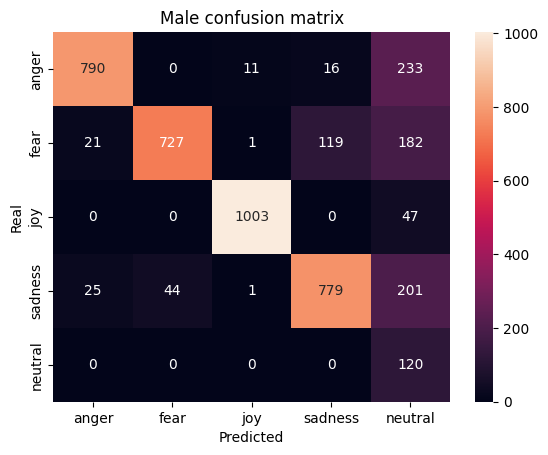

In [23]:
# Heatmap

import seaborn as sns

sns.heatmap(cm_male, annot=True, fmt="d", xticklabels=["anger", "fear", "joy", "sadness", "neutral"], yticklabels=["anger", "fear", "joy", "sadness", "neutral"])


# Add "Real"

plt.ylabel("Real")
plt.xlabel("Predicted")

plt.title("Male confusion matrix")

Text(0.5, 23.52222222222222, 'Predicted')

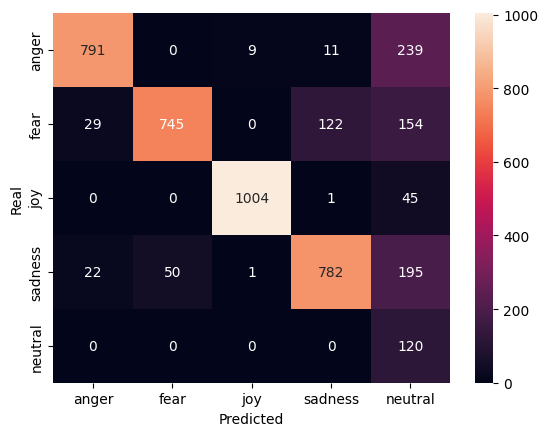

In [22]:
# Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm_female, annot=True, fmt="d", xticklabels=["anger", "fear", "joy", "sadness", "neutral"], yticklabels=["anger", "fear", "joy", "sadness", "neutral"])

# Add "Real"
plt.title("Female confusion matrix")
plt.ylabel("Real")
plt.xlabel("Predicted")


## Race

In [27]:
afroamerican = df[df["race"] == "African-American"]
european = df[df["race"] == "European"]

cm_afroamerican = confusion_matrix(
    afroamerican["emotion"], afroamerican["ekman_pred"],
    labels=["anger", "fear", "joy", "sadness", "neutral"])

cm_european = confusion_matrix(
    european["emotion"], european["ekman_pred"],
    labels=["anger", "fear", "joy", "sadness", "neutral"])


Text(0.5, 23.52222222222222, 'Predicted')

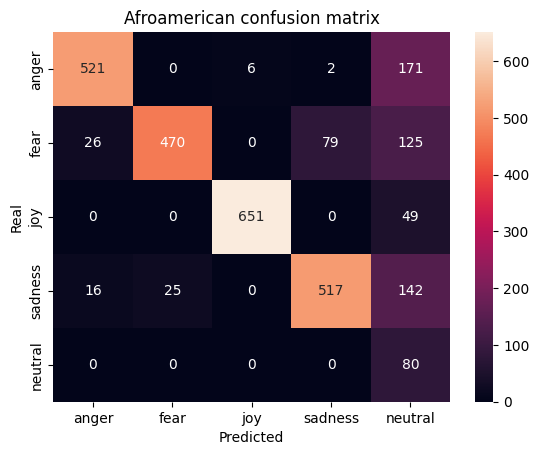

In [28]:

sns.heatmap(cm_afroamerican, annot=True, fmt="d", xticklabels=["anger", "fear", "joy", "sadness", "neutral"], yticklabels=["anger", "fear", "joy", "sadness", "neutral"])

# Add "Real"
plt.title("Afroamerican confusion matrix")
plt.ylabel("Real")
plt.xlabel("Predicted")


Text(0.5, 23.52222222222222, 'Predicted')

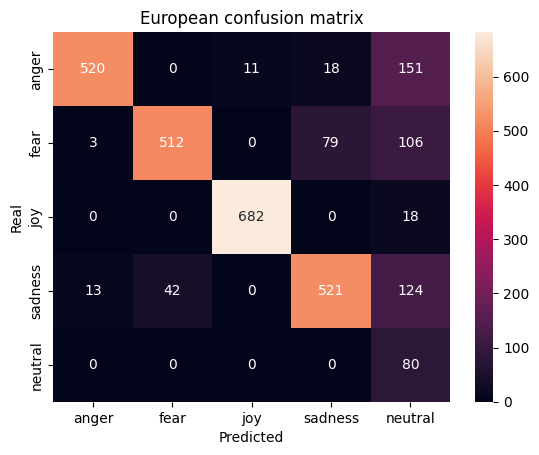

In [29]:

sns.heatmap(cm_european, annot=True, fmt="d", xticklabels=["anger", "fear", "joy", "sadness", "neutral"], yticklabels=["anger", "fear", "joy", "sadness", "neutral"])

# Add "Real"
plt.title("European confusion matrix")
plt.ylabel("Real")
plt.xlabel("Predicted")
